In [55]:
import numpy as np
import pandas as pd
import csv
from helper import clean_text, plot_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')    # fivethirtyeight, ggplot, seaborn
%matplotlib inline
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from copy import deepcopy
from random import randint
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.base import TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict, Counter

In [3]:
random_state = 52

# Merge full dataset

In [4]:
file = 'source/df_true_v2.pkl'
df_true = pd.read_pickle(file)
df_true['label'] = 1
print(df_true.shape)
#df_true.head()

(390, 13)


In [5]:
file = 'source/df_fake_v2.pkl'
df_fake = pd.read_pickle(file)
df_fake['label'] = 0
print(df_fake.shape)
#df_fake.head()

(354, 13)


In [6]:
# concatenate and shuffle
df = pd.concat([df_true, df_fake])
df['full_text'] = df['title'] + '. ' + df['text']
df = df.sample(frac=1.0, random_state=random_state)
print(df.shape)
#df.head()

(744, 14)


In [7]:
# clean_text
df['full_text_clean'] = df['full_text'].apply(clean_text)
df['full_text_clean'] = df['full_text_clean'].apply(lambda x: x.replace('!.', '!'))
df.head()

,title,text,name,date,stars,color,is_vine_voice,has_images,found_helpful,verified_purchase,lang,kw,label,full_text,full_text_clean
424,Great bluetooth headphones,Really enjoying these Bluetooth wireless headp...,Beach girl,2023-06-23,5,NaN,True,False,0,False,ENGLISH,"[bluetooth wireless headphones, good quality s...",0,Great bluetooth headphones. Really enjoying th...,Great bluetooth headphones. Really enjoying th...
57,Great Sound With Quality!!,These headphones have a deep rich sound. If yo...,PRASANNA KHARYA,2022-06-18,5,NaN,False,False,0,True,ENGLISH,"[ear pads, deep rich sound, headphones, time, ...",1,Great Sound With Quality!!. These headphones h...,Great Sound With Quality!! These headphones ha...
205,Great for its price!,I just ordered them and took them for a spin a...,Jacob Schniepp,2023-09-07,5,white,False,False,0,True,ENGLISH,"[ears perfectly, absolutely love, price, pair,...",0,Great for its price!. I just ordered them and ...,Great for its price! I just ordered them and t...
428,Doesn’t hurt my ear,I was a little scared when I first got it but ...,Shantelle carter,2023-06-28,5,NaN,True,True,0,False,ENGLISH,"[didn’t hurt, hurt my ear, listened to music, ...",0,Doesn’t hurt my ear. I was a little scared whe...,Doesn't hurt my ear. I was a little scared whe...
343,WOW!!!!!,Verified Purchase\nI did not expect to get thi...,Jimmy_Jamzz,2023-09-03,5,black,False,True,0,False,ENGLISH,"[verified purchase, Verified Purchase, kind of...",0,WOW!!!!!. Verified Purchase\nI did not expect ...,WOW!!!!! Verified Purchase I did not expect to...


In [8]:
# no duplicates
df[ df.duplicated(subset=['full_text_clean'], keep=False) ].sort_values(by='full_text_clean')

,title,text,name,date,stars,color,is_vine_voice,has_images,found_helpful,verified_purchase,lang,kw,label,full_text,full_text_clean


In [9]:
# stratified train test split in the dataframe
X = df['full_text_clean'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

df['subset'] = df['full_text_clean'].apply( lambda x: 'train' if x in X_train else 'test')
print(df['subset'].value_counts())
print(df[df['label']==0]['subset'].value_counts())
print(df[df['label']==1]['subset'].value_counts())
del X_train, X_test, y_train, y_test

train    595
test     149
Name: subset, dtype: int64
train    283
test      71
Name: subset, dtype: int64
train    312
test      78
Name: subset, dtype: int64


In [18]:
print(df.shape)
df.head()

(744, 14)


,title,text,name,date,stars,color,is_vine_voice,has_images,found_helpful,verified_purchase,keywords,label,full_text_clean,subset
272,Excellent product for the price.,"Verified Purchase\nVery solid product, for the...",B,2020-09-05,4,black,False,False,0,True,verified purchase|Verified Purchase|solid prod...,1,Excellent product for the price.. Verified Pur...,train
337,My daughter loves these,Got these for my daughter as she gets ready fo...,Dani,2023-08-10,5,NaN,False,False,0,True,ready for school|daughter|started|purchase,0,My daughter loves these. Got these for my daug...,train
17,What's not to Love?,I recently ordered the BOLOXA A17 Bluetooth He...,tammi,2023-08-01,5,NaN,False,False,0,True,i’m highly satisfied|forget i’m wearing|tad le...,0,What's not to Love?. I recently ordered the BO...,train
245,Great Earbuds But...,Verified Purchase\nThese are great if you want...,Jon,2020-07-31,4,black,False,False,0,True,verified purchase|good sound|highly recommend|...,1,Great Earbuds But.... Verified Purchase These ...,train
314,Works well,The headphones were easy to connect to my devi...,Dan Cool,2023-08-10,5,NaN,False,False,0,True,i’m listening|comfortable to wear|headphones w...,0,Works well. The headphones were easy to connec...,train


In [11]:
# drop and rename column before saving file - makes more sense this way
df = df.drop(['lang', 'full_text'], axis=1)
df = df.rename(columns={'kw': 'keywords'})
df['keywords'] = df['keywords'].apply(lambda x: '|'.join(x))

In [15]:
file = 'source/full_dataset.csv'
df = df.sample(frac=1.0, random_state=random_state)
df.to_csv(file, quoting=csv.QUOTE_MINIMAL)

# Classifiers

In [19]:
X_train = df[df['subset']=='train']['full_text_clean'].values
y_train = df[df['subset']=='train']['label'].values
X_test  = df[df['subset']=='test']['full_text_clean'].values
y_test  = df[df['subset']=='test']['label'].values

X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=random_state)
X_test, y_test   = sklearn.utils.shuffle(X_test, y_test, random_state=random_state)
print('Shape of datasets:', X_train.shape, X_test.shape, y_train.shape, y_test.shape )

unique, counts = np.unique(y_train, return_counts=True)
print('Labels in train set:  ', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Labels in test set:   ', dict(zip(unique, counts)))

Shape of datasets: (595,) (149,) (595,) (149,)
Labels in train set:   {0: 283, 1: 312}
Labels in test set:    {0: 71, 1: 78}


## Logistic Regression

In [215]:
# VECTORIZER PARAMETERS
vect_params = {
    'max_df': 1.0,
    'min_df': 1,    
    'analyzer': 'word',
    'ngram_range': (1,2),
    'binary': False,
    'stop_words': 'english',
}

# CLASSIFIER PARAMETERS
clf_params_lr = {   
    
    'solver': 'liblinear',          # default=’lbfgs’ {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
                                    # small dataset => ‘liblinear’ big dataset => ‘sag’ and ‘saga’ (faster);
                                    # multiclass => ‘newton-cg’, ‘sag’, ‘saga’, ‘lbfgs’; ‘liblinear’ only for ovr
                                    # supported penalties by solver: ‘newton-cg’, ‘lbfgs’, ‘sag’ - [‘l2’, ‘none’],
                                    # ‘liblinear’ - [‘l1’, ‘l2’],
                                    # ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

    'penalty': 'l2',                # ‘l1’, ‘l2’, ‘elasticnet’ (both), ‘none’, default=’l2’ (not for al solvers)
    'class_weight': None,           # default=None, dict or ‘balanced'
    
    'multi_class': 'auto',          #  default=’auto’, {‘auto’, ‘ovr’, ‘multinomial’},
                                    # 'ovr’ => binary problem fit for each label
                                    # ‘multinomial’ => multinom. loss fit across entire prob distrib.
                                    # ‘auto’ selects ‘ovr’ for binary classif. or solver=’liblinear’,
                                    # otherwise ‘multinomial’
        
    'max_iter': 500,                # default=100, iters for solvers to converge
    'C': 0.25,                       # default 1.0, inverse regularization strength, smaller => stronger regularization
    'dual': False,                  # default=False (dual formulation only for l2  with liblinear solver
                                    # Prefer dual=False when n_samples > n_features
    'tol': 1e-4,                    # stopping criteria, default=1e-4
    'fit_intercept': True,          # default True; whether to fit bias / interceptbe added to the decision function
    'intercept_scaling': 1,         # default=1, for solver ‘liblinear’ and self.fit_intercept=True (additional term)
    'l1_ratio': None,               # default = None, elastic-Net mixing param, [0,1],
                                    # only for penalty='elasticnet'. l1_ratio=0 => penalty='l2',
                                    # l1_ratio=1 => penalty='l1', combination of L1 and L2 if in between    
    'verbose': 0,
    'warm_start': False,    
    'random_state': random_state,
    'n_jobs': -1,
}

#vectorizer = TfidfVectorizer( **vect_params )
vectorizer = CountVectorizer( **vect_params )

clf = LogisticRegression( **clf_params_lr )

In [216]:
# FIT AND TEST MODEL
model_lr = Pipeline( steps=[('vect', vectorizer), ('clf', clf)] )
model_lr.fit( X_train, y_train )

# test
y_pred = model_lr.predict( X_test )
print( classification_report( y_test, y_pred, target_names=labels) )

/Users/andrew/opt/anaconda3/envs/top/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

        fake       0.75      0.79      0.77        71
        true       0.80      0.76      0.78        78

    accuracy                           0.77       149
   macro avg       0.77      0.77      0.77       149
weighted avg       0.77      0.77      0.77       149



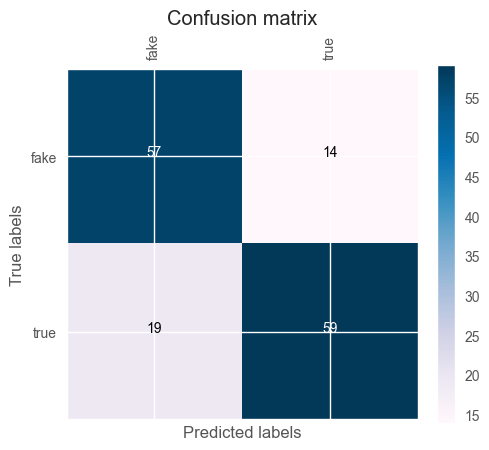

In [212]:
cm = confusion_matrix( y_test, y_pred )
plot_confusion_matrix( cm, labels, fig_size=(5,5), fmt='d')

## Naive Bayes

In [274]:
vect_params = {
    'max_df': 1.0,
    'min_df': 5,    
    'analyzer': 'word',
    'ngram_range': (1,2),
    'binary': False,
    'stop_words': 'english',
}

# CLASSIFIER PARAMETERS
clf_params = {
    'alpha': 1.0,
    'fit_prior': True,
}

#vectorizer = TfidfVectorizer( **vect_params )
vectorizer = CountVectorizer( **vect_params )

clf = MultinomialNB( **clf_params )

In [275]:
# TFIDF LOOKS SLIGHTLY BETTER? OR IS IT JUST NO CRODD-VALIDATED?
model_nb =  Pipeline( steps=[('vect', vectorizer), ('clf', clf)] )
model_nb.fit( X_train, y_train )

# testset 1
y_pred = model_nb.predict( X_test )
print( classification_report( y_test, y_pred, target_names=labels) )

              precision    recall  f1-score   support

        fake       0.78      0.66      0.72        71
        true       0.73      0.83      0.78        78

    accuracy                           0.75       149
   macro avg       0.76      0.75      0.75       149
weighted avg       0.76      0.75      0.75       149



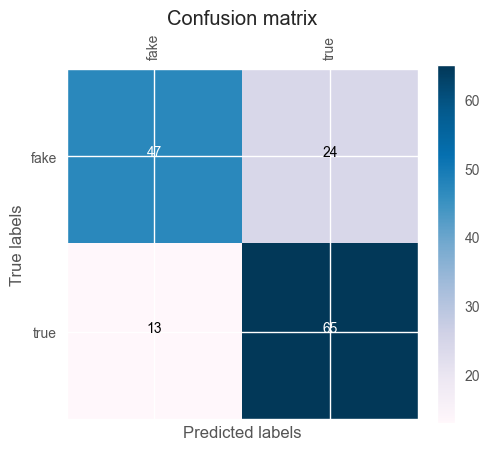

In [276]:
cm = confusion_matrix( y_test, y_pred )
plot_confusion_matrix( cm, labels, fig_size=(5,5), fmt='d')

## XGBoost Classifier

In [130]:
clf_params_xgb = {
    'n_estimators': 100,
    'max_depth': None,
    'learning_rate': 0.2,                                # eta
    'objective': 'multi:softmax',                        # multi:softmax, multi:softprob, rank:pairwise
    'eval_metric': 'mlogloss',                           # multiclass - merror, mlogloss
    'base_score': 0.25,
    'booster': 'gbtree',                                 # gbtree, dart
    'tree_method': 'approx',                             # auto, exact, approx, hist and gpu_hist
    'importance_type': 'gain',                           # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
    'gamma': 0,                                       # larger - more conservative, [0, inf], default 0
    'reg_alpha': 0,                                    # L1 reg., larger - more conservative, default 0
    'reg_lambda': 1,                                     # L2 rreg., larger - more conservative, default 1
    'sampling_method': 'uniform',                        # uniform, gradient_based
    'max_delta_step': 1,                                 # 1-10
    'min_child_weight': 1,
    'subsample': 1,                                   # 0-1  (lower values prevent overfitting)    
    'colsample_bylevel': 1,                            # 0-1
    'colsample_bynode': 1,                            # optimized for higher recall
    'colsample_bytree': 1,                            # 0-1  
    'seed': 5,
    'num_class': 2,
    #'use_label_encoder': False,
    'random_state': random_state,
    'n_jobs': -1,    
}

vect_params_xgb = {
    'max_df': 1.0,                             
    'min_df': 1,    
    'analyzer': 'word',
    'ngram_range': (1,2), 
    'binary': False,
    'stop_words': 'english',
}

vectorizer = TfidfVectorizer( **vect_params_xgb )
#vectorizer = CountVectorizer( **vect_params_xgb )

clf = XGBClassifier( **clf_params_xgb )

In [131]:
# FIT AND TEST MODEL
model_xgb = Pipeline( steps=[('vect', vectorizer), ('clf', clf)] )
model_xgb.fit( X_train, y_train )
y_pred = model_xgb.predict( X_test )

In [132]:
# CLASSIFICATION REPORT
labels = ['fake', 'true']
print( classification_report( y_test, y_pred, target_names=labels) )

              precision    recall  f1-score   support

        fake       0.79      0.85      0.82        71
        true       0.85      0.79      0.82        78

    accuracy                           0.82       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.82      0.82      0.82       149



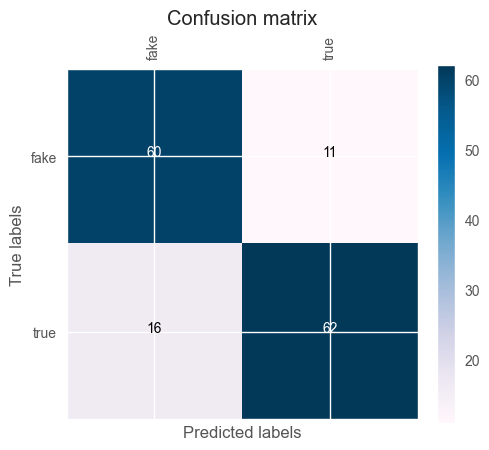

In [133]:
# CONFUSION MATRIX
cm = confusion_matrix( y_test, y_pred )
plot_confusion_matrix( cm, labels, fig_size=(5,5), fmt='d')

# Feature Importance by Naive Bayes

In [278]:
# TOTAL NUMBER OF CLASSES AND FEATURES
classifier = model_nb['clf']
print(classifier.classes_)
classifier.feature_log_prob_.shape

[0 1]


(2, 1494)

In [296]:
# PRINT MOST IMPORTANT FEATURES PER CATEGORY
n = 500
dict_important = dict()
print(f'PRINT {n} MOST IMPORTANT FEATURES FOR EACH CLASS (LAST IS LEAST IMPORTANT):\n')
for i in classifier.classes_:    
    print('********** ' + str(i) + ' ********************')
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()
    important = np.take(model_nb['vect'].get_feature_names_out(), prob_sorted[-n:]).tolist()
    dict_important[i] = important#[::-1]
    print(type(important))
    print(dict_important[i])
    print()

PRINT 500 MOST IMPORTANT FEATURES FOR EACH CLASS (LAST IS LEAST IMPORTANT):

********** 0 ********************
<class 'list'>
['item', 'trying', 'things', 'set headphones', 'reading', 'really like', 'hour', 'phenomenal', 'life excellent', 'spend', 'voice', 'real', 'percent', 'turned', 'build', 'ear design', 'single charge', 'additional', 'husband', 'reviewed united', 'charge case', 'satisfied', 'worn', 'away', 'sound easy', 'charger', 'reviewed', 'allows', 'beats', 'change', 'buck', 'stay ears', '2023', 'arrived', 'surprisingly', 'said', 'affordable price', 'year old', 'cancelling', 'recommend product', 'star', 'purse', 'simply', 'cancellation', 'beat', 'wow', 'apple', 'unbeatable', 'providing', 'forget', 'larger', 'fit ear', 'fact', 'extra', 'talking', 'piece', 'tracks', 'exceeded expectations', 'couldn', 'enjoying', 'crystal', 'crystal clear', 'vigorous', 'movement', 'durable', 'think', 'noise cancellation', 'noise cancelling', 'digital', 'tested', 'friends', 'taking', 'outside noise

In [297]:
df_important = pd.DataFrame(dict_important)
file = 'source/vocab_2ngram_model.xlsx'
df_important.to_excel( file )
df_important.head(25)

,0,1
0,item,lower
1,trying,feels
2,things,mind
3,set headphones,pay
4,reading,gets
5,really like,watching
6,hour,husband
7,phenomenal,mono
8,life excellent,fit ear
9,spend,audio quality


In [298]:
# overlap?
print(df_important.shape)
overlap = [i for i in df_important[0].values if i in df_important[1].values]
len(overlap)

(500, 2)


341

__Among the 1000 most important features for categories 0 and 1, there are 654 that occur in both categories!__

In [299]:
# only in category 0
cat0_only = [i for i in df_important[0].values if i not in overlap]
print(len(cat0_only))
print(cat0_only)

159
['set headphones', 'reading', 'really like', 'phenomenal', 'life excellent', 'real', 'percent', 'ear design', 'single charge', 'additional', 'reviewed united', 'charge case', 'worn', 'sound easy', 'reviewed', 'beats', 'buck', 'stay ears', '2023', 'affordable price', 'year old', 'recommend product', 'purse', 'simply', 'beat', 'unbeatable', 'providing', 'forget', 'larger', 'extra', 'tracks', 'exceeded expectations', 'enjoying', 'crystal', 'crystal clear', 'vigorous', 'movement', 'digital', 'friends', 'usb cable', 'heard', 'headphones use', 'store', 'provide', 'united', 'eq', 'ear tips', 'headphones comfortable', 'united states', 'definitely recommend', 'states', 'started', 'easy pair', 'stable', 'securely', 'sessions', 'intense', 'game', 'indicator', 'leave', 'uses', 'boloxa headphones', 'adjust volume', 'audio experience', 'a17 headphones', 'family', 'seconds', 'comfortable great', 'recently', 'weight', 'daughter', 'particularly', 'clarity', 'deep', 'especially price', 'comfortable 

In [302]:
# only in cat 1
cat1_only = [i for i in df_important[1].values if i not in overlap]
print(len(cat1_only))
print(cat1_only)

159
['lower', 'feels', 'mind', 'pay', 'gets', 'mono', 'frequently', 'lights', 'unless', 'travel', 'make sure', '25', 'brands', 'plan', 've owned', 'fairly', 'instead', 'warranty', 'right ear', 'nicely', 'ear bud', 'noises', 'wireless ear', 'quiet', 'response', 'recommended', 'month', 'aren', 'reason', 'click', 'video', 'true wireless', 'best headphones', 'left ear', 'problems', 'rubber', 'says', 'seller', 'bucks', 'totally', 'honest', 'believe', 'cancel', 'kind', 'considering', 'wouldn', 'walking', 'headphones verified', 'settings', 'room', 'second pair', 'world', 'huge', 'smaller', 'higher', 'literally', 'complaint', 'right earbud', 'wires', 'hold charge', 'past', 'gift', 'purchase great', 'audiophile', 'feet', 'great battery', 'feel like', 'owned', 'overall great', 'goes', 'start', 'person', 'meetings', 'don know', 'straight', 'bt', 'bose', 'micro usb', 'packaging', 'pair wireless', 'lasted', 'left earbud', 'maybe', 'okay', 'micro', 'lost', 'support', 'mid', 'read', 'usually', 'night

# Apply models back on dataset
Trying to reverse engineer Fakespot

In [318]:
df['pred_lr']  = df['full_text_clean'].apply( lambda x: model_lr.predict_proba([x])[0][1] )
df['pred_nb']  = df['full_text_clean'].apply( lambda x: model_nb.predict_proba([x])[0][1] )
df['pred_xgb'] = df['full_text_clean'].apply( lambda x: model_xgb.predict_proba([x])[0][1] )

In [321]:
df['pred_avg'] = df.apply( lambda x: round(sum([x['pred_lr'], x['pred_nb'], x['pred_xgb']])/3, 4), axis=1 )
df.head(25)

,title,text,name,date,stars,color,is_vine_voice,has_images,found_helpful,verified_purchase,keywords,label,full_text_clean,subset,pred_lr,pred_nb,pred_xgb,pred_avg
272,Excellent product for the price.,"Verified Purchase\nVery solid product, for the...",B,2020-09-05,4,black,False,False,0,True,verified purchase|Verified Purchase|solid prod...,1,Excellent product for the price.. Verified Pur...,train,0.953143,1.000000e+00,0.998838,0.9840
337,My daughter loves these,Got these for my daughter as she gets ready fo...,Dani,2023-08-10,5,NaN,False,False,0,True,ready for school|daughter|started|purchase,0,My daughter loves these. Got these for my daug...,train,0.281419,1.038947e-01,0.094149,0.1598
17,What's not to Love?,I recently ordered the BOLOXA A17 Bluetooth He...,tammi,2023-08-01,5,NaN,False,False,0,True,i’m highly satisfied|forget i’m wearing|tad le...,0,What's not to Love?. I recently ordered the BO...,train,0.009889,3.547906e-29,0.002744,0.0042
245,Great Earbuds But...,Verified Purchase\nThese are great if you want...,Jon,2020-07-31,4,black,False,False,0,True,verified purchase|good sound|highly recommend|...,1,Great Earbuds But.... Verified Purchase These ...,train,0.950728,1.000000e+00,0.997595,0.9828
314,Works well,The headphones were easy to connect to my devi...,Dan Cool,2023-08-10,5,NaN,False,False,0,True,i’m listening|comfortable to wear|headphones w...,0,Works well. The headphones were easy to connec...,train,0.170268,4.345915e-03,0.016410,0.0637
269,Happy with these,"Verified Purchase\nOverall, my experience has ...",Dave,2020-03-03,4,black,False,False,2,True,headphones pair easily|cell phone headphones|p...,1,"Happy with these. Verified Purchase Overall, m...",test,0.786480,9.999148e-01,0.996600,0.9277
388,Great headphones,These headphones are great. They hold a charge...,Izzie Wroblewski,2023-08-17,5,NaN,True,True,0,False,headphones are great|lot of hair|music modes e...,0,Great headphones. These headphones are great. ...,train,0.122781,7.136124e-04,0.033679,0.0524
215,The are great quality,I like that they look like AirPods pro and hav...,Yazmin Jackson,2023-09-07,5,white,False,False,0,True,airpods pro|long time|AirPods pro|sound|heard,0,The are great quality. I like that they look l...,train,0.153709,5.824523e-02,0.028466,0.0801
332,Highly reccomend this item.,Highly reccomend this item.\nSound quality and...,Ashley,2023-08-07,5,NaN,False,False,0,True,highly reccomend|sound quality|Highly reccomen...,0,Highly reccomend this item.. Highly reccomend ...,train,0.204494,5.304078e-02,0.150265,0.1359
372,Very Reliable,Verified Purchase\nI have had this for almost ...,Jared Craw,2023-05-14,5,black,False,False,1,True,verified purchase|sound quality|absolutely rec...,1,Very Reliable. Verified Purchase I have had th...,train,0.975477,9.999535e-01,0.997510,0.9910


In [322]:
file = 'source/full_dataset_with_predictions.csv'
df.to_csv(file, quoting=csv.QUOTE_MINIMAL)